# Wrangle
In this notebook, we will gain a first overview of our data and wrangle it to make it usable for further analysis and modeling. 

## Imports

In [377]:
import os
from multiprocessing import Pool

import numpy as np
import pandas as pd
import pycountry
from matplotlib import pyplot as plt
from tqdm import tqdm

tqdm.pandas()

## Constants

In [519]:
RAW_DATA_PATH = "../data/raw/"
METEO_DATA_PATH = os.path.join(RAW_DATA_PATH, "gsoy")
GAPMINDER_DATA_PATH = os.path.join(RAW_DATA_PATH, "gapminder")

# 1. Meteorological data
The data source is the [National Centers for Enviromental Information](https://www.ncei.noaa.gov/metadata/geoportal/rest/metadata/item/gov.noaa.ncdc:C00947/html) and contains 58 meteorological variables on a yearly frequency for locations worldwide.

## 1.1 Load data
The dataset contains multiple CSV files from different weather stations. We will first of all load all of those files and combine them to one data frame.

In [16]:
meteo_csv_files = list(
    filter(lambda fname: fname.endswith(".csv"), os.listdir(METEO_DATA_PATH))
)

print(f"{METEO_DATA_PATH} contains {len(meteo_csv_files)} CSV files.")

meteo_dfs = []
for fname in tqdm(meteo_csv_files, total=len(meteo_csv_files)):
    tmp_df = pd.read_csv(os.path.join(METEO_DATA_PATH, fname))
    meteo_dfs.append(tmp_df)

meteo_df_full = pd.concat(meteo_dfs)  # this will take a while!
meteo_df_full.head()

../data/raw/gsoy contains 82292 CSV files.


100%|████████████████████████████████████| 82292/82292 [04:09<00:00, 330.44it/s]


## 1.2 Select relevant variables
The dataset contains 58 meteorological variables which are further described [here](https://www.ncei.noaa.gov/data/global-summary-of-the-year/doc/GSOM_GSOY_Description_Document_v1.0.2_20200219.pdf). As some variables are available in Fahrenheit and Celsius, and some of them are not of interest for us, we will only select the relevant ones.

The ones that will be selected by us are:
- **STATION** - (11 characters) is the station identification code. 
- **NAME** - (max 50 characters) is the name of the station (usually city/airport name).
- **LATITUDE** - (8 characters) is the latitude (decimated degrees w/Northern Hemisphere values > 0).
- **LONGITUDE** - (9 characters) is the longitude (decimated degrees w/Western Hemisphere values < 0 and Eastern Hemisphere values > 0)
- **ELEVATION** - (13 characters) is the elevation above mean sea level in meters (to nearest thousandth of a meter).
- **DATE** - is the year of the record.
- **AWND** – Annual Average Wind Speed. Given in miles per hour.
- **DT00** – Number of days with minimum temperature <= 0 degrees Fahrenheit/-17.8 degrees Celsius.
- **DT32** – Number of days with minimum temperature <= 32 degrees Fahrenheit/0 degrees Celsius.
- **DX32** – Number of days with maximum temperature <= 32 degrees Fahrenheit/0 degrees Celsius.
- **DX70** – Number of days with maximum temperature <= 70 degrees Fahrenheit/21.1 degrees Celsius.
- **DX90** – Number of days with maximum temperature >= 90 degrees Fahrenheit/32.2 degrees Celsius.
- **DYTS** – Total number of days in the year where one or more thunderstorms were reported. 
- **EMNT** – Extreme minimum temperature for year. Lowest daily minimum temperature for the year. 
- **EMXP** – Highest daily total of precipitation in the year. Given in inches.
- **EMXT** – Extreme maximum temperature for year. Highest daily maximum temperature for the year. 
- **PRCP** – Total Annual Precipitation. Given in inches.
- **SNOW** – Total Annual Snowfall. Given in inches. 
- **TAVG** – Average Annual Temperature. Computed by adding the unrounded annual maximum (TMAX) and minimum (TMIN) temperatures and dividing by 2. Fahrenheit units.
- **TMAX** – Average Annual Maximum Temperature. Average of mean monthly maximum temperatures given in Fahrenheit.
- **TMIN** – Average Annual Minimum Temperature. Average of mean monthly minimum temperatures given in Fahrenheit.
- **TSUN** – Annual total sunshine in minutes.

In [956]:
relevant_vars = [
    "STATION",
    "NAME",
    "LATITUDE",
    "LONGITUDE",
    "ELEVATION",
    "DATE",
    "AWND",
    "DT00",
    "DT32",
    "DX32",
    "DX70",
    "DX90",
    "DYTS",
    "EMNT",
    "EMXP",
    "EMXT",
    "PRCP",
    "SNOW",
    "TAVG",
    "TMAX",
    "TMIN",
    "TSUN",
]
print(f"Shape before variable filtering: {meteo_df_full.shape}")
meteo_df_relevant = meteo_df_full[relevant_vars]
print(f"Shape after variable filtering: {meteo_df_relevant.shape}")

Shape before variable filtering: (2533245, 216)
Shape after variable filtering: (2533245, 22)


## 1.3 Select relevant years
To keep the dataset size managable, we will only consider observations with `DATE >= 1950`.

In [957]:
print(f"Shape before year filtering: {meteo_df_relevant.shape}")
meteo_df_relevant_year = meteo_df_relevant[meteo_df_relevant["DATE"] >= 1950]
print(f"Shape after year filtering: {meteo_df_relevant_year.shape}")

Shape before year filtering: (2533245, 22)
Shape after year filtering: (1849783, 22)


## 1.4 Examine missing values per variable

In [958]:
df = meteo_df_relevant_year

variable_descriptions = []
for var in df.columns.values:
    desc = {
        "variable": var,
        "ndv": df[var].nunique(),
        "missing_absolute": df[var].isna().sum(),
        "missing_relative": df[var].isna().sum() / len(df[var]),
    }
    variable_descriptions.append(desc)
variable_descriptions = pd.DataFrame(variable_descriptions)
variable_descriptions

,variable,ndv,missing_absolute,missing_relative
0,STATION,76054,0,0.000000
1,NAME,73525,0,0.000000
2,LATITUDE,45316,0,0.000000
3,LONGITUDE,50015,0,0.000000
4,ELEVATION,8541,13084,0.007073
5,DATE,73,0,0.000000
6,AWND,150,1825412,0.986825
7,DT00,269,1136865,0.614594
8,DT32,367,1136865,0.614594
9,DX32,347,1122249,0.606692


We can see that there are a lot of missing values for all variables except the ones discribing the location and the date. Especially for `AWND`, `DYTS`, `SNOW` and  `TSUN` over 70% of the values are missing. Therefore, we will remove those variables, as we wont fix those with any imputation strategies. 



In [959]:
df = df.drop(["AWND", "DYTS", "TSUN", "SNOW"], axis=1)

## 1.5 Examine missing values per year
We will now investigate, if those missing values are randomly scattered or if they are only missing for certain years and stations.

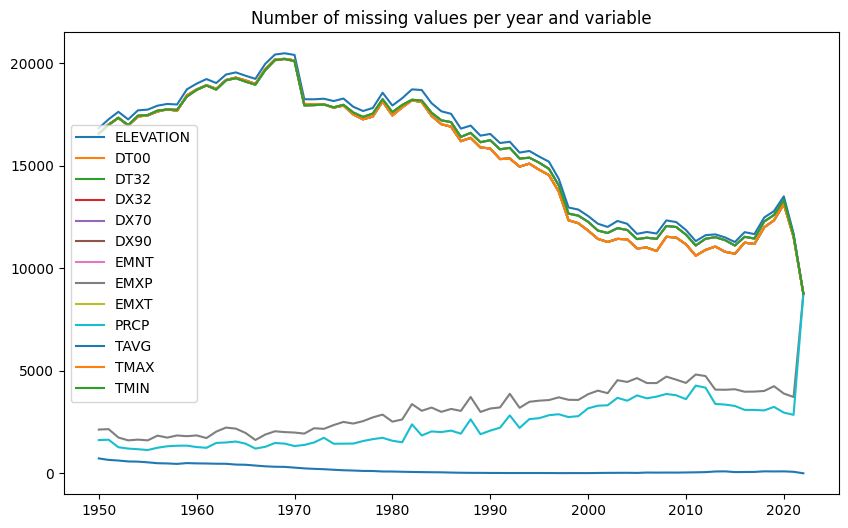

In [960]:
missing_per_year = df.groupby(["DATE"]).agg(lambda x: x.isna().sum())

fig, ax = plt.subplots(figsize=(10, 6))

missing_per_year
for var in missing_per_year.columns.values:
    if (missing_per_year[var] > 0).any():
        ax.plot(missing_per_year.index, missing_per_year[var], label=var)
ax.legend(loc="best")
ax.set_title("Number of missing values per year and variable")
plt.show()

We cannot observe a concrete year for which the number of missing values is a lot higher than for others. Therefore we cannot simple remove a year to get rid of missing values.

## 1.5 Examine missing values by station

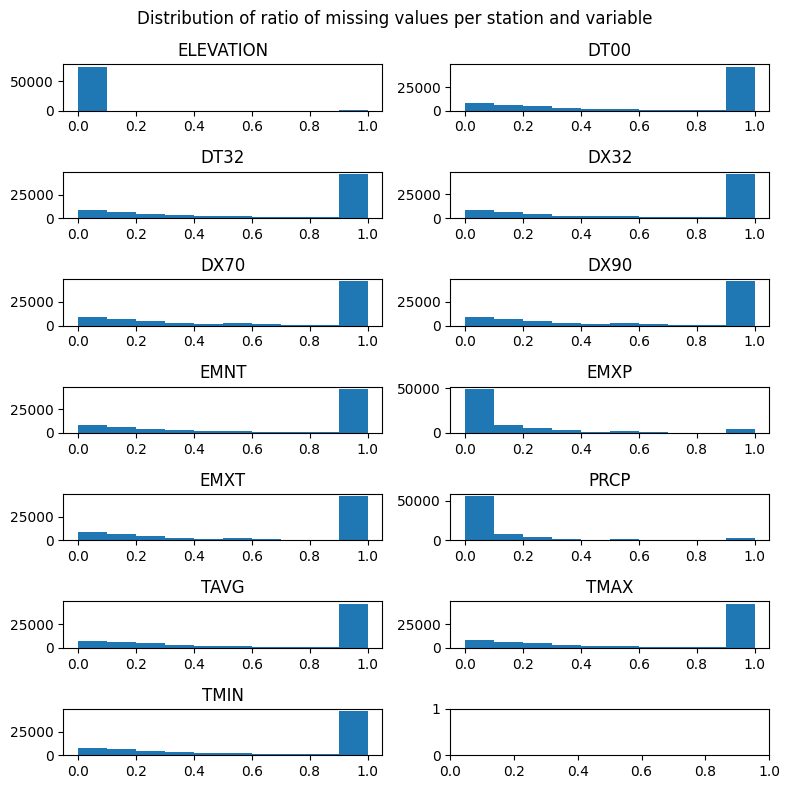

In [961]:
missing_per_location = df.groupby(["STATION"]).agg(
    lambda x: x.isna().sum() / len(x)
)  # we use the number of total values to normalize

num_missing_loc_vars = sum((missing_per_location > 0).any())

fig, axs = plt.subplots(num_missing_loc_vars // 2 + 1, 2, figsize=(8, 8))
fig.suptitle("Distribution of ratio of missing values per station and variable")
axs = axs.flatten()
idx = 0
for var in missing_per_location.columns.values:
    if sum(missing_per_location[var]) > 0:
        axs[idx].hist(missing_per_location[var])
        axs[idx].set_title(var)
        idx += 1
plt.tight_layout()
plt.show()

From the histograms above, we can observe that there are many stations where over 90% of values for a variable are missing. We will take a closer look at those stations and then try remove them. 

### 1.5.1 Investigate stations with high number of missing values

In [962]:
print(f"Number of stations: {len(missing_per_location)}")
print(
    f"Number of stations with any variable >90% missing: {len(missing_per_location[(missing_per_location > 0.9).any(axis=1)])}"
)

Number of stations: 76054
Number of stations with any variable >90% missing: 49413


## 1.6 Find country by FIPS 10-4 code and map to alpha 2  
Mapping data obtained from [this Github repository](https://github.com/mysociety/gaze/blob/master/data/fips-10-4-to-iso-country-codes.csv).

In [963]:
country_map = pd.read_csv(os.path.join(RAW_DATA_PATH, "fips_country_map.csv"))
display(country_map.head())

fips_iso_dict = dict(zip(country_map["FIPS 10-4"], country_map["ISO 3166"]))
fips_name_dict = dict(zip(country_map["FIPS 10-4"], country_map["Name"]))


def resolve_country(station_name):
    country_suffix = station_name.split(",")[-1]
    fips_10_4 = country_suffix.split(" ")[-1]
    try:
        country_name = fips_name_dict[fips_10_4]
        alpha2 = fips_iso_dict[fips_10_4]
    except Exception as e:
        country_name = "UNKNOWN"
        alpha2 = "UNKNOWN"

    if pd.isna(country_name):
        country_name = "UNKNOWN"
    if pd.isna(alpha2):
        alpha2 = "UNKNOWN"

    return alpha2 + ";" + fips_10_4 + ";" + country_name


df.loc[:, "COUNTRY_INFO"] = df["NAME"].apply(resolve_country)
df.loc[:, "ALPHA2"] = df["COUNTRY_INFO"].apply(lambda x: x.split(";")[0])
df.loc[:, "FIPS10_4"] = df["COUNTRY_INFO"].apply(lambda x: x.split(";")[1])
df.loc[:, "COUNTRY"] = df["COUNTRY_INFO"].apply(lambda x: x.split(";")[2])
df = df.drop("COUNTRY_INFO", axis=1)
df.head()

,FIPS 10-4,ISO 3166,Name
0,AF,AF,Afghanistan
1,AX,-,Akrotiri
2,AL,AL,Albania
3,AG,DZ,Algeria
4,AQ,AS,American Samoa


,STATION,NAME,LATITUDE,LONGITUDE,ELEVATION,DATE,DT00,DT32,DX32,DX70,...,EMNT,EMXP,EMXT,PRCP,TAVG,TMAX,TMIN,ALPHA2,FIPS10_4,COUNTRY
1,USC00401946,"COLLEGE JUNCTION, TN US",35.51667,-85.28333,264.9,1950,NaN,NaN,NaN,NaN,...,NaN,54.1,NaN,1493.7,NaN,NaN,NaN,US,US,United States
2,USC00401946,"COLLEGE JUNCTION, TN US",35.51667,-85.28333,264.9,1951,NaN,NaN,NaN,NaN,...,NaN,73.7,NaN,1466.8,NaN,NaN,NaN,US,US,United States
3,USC00401946,"COLLEGE JUNCTION, TN US",35.51667,-85.28333,264.9,1952,NaN,NaN,NaN,NaN,...,NaN,68.8,NaN,1110.3,NaN,NaN,NaN,US,US,United States
4,USC00401946,"COLLEGE JUNCTION, TN US",35.51667,-85.28333,264.9,1953,NaN,NaN,NaN,NaN,...,NaN,96.0,NaN,1219.5,NaN,NaN,NaN,US,US,United States
5,USC00401946,"COLLEGE JUNCTION, TN US",35.51667,-85.28333,264.9,1954,NaN,NaN,NaN,NaN,...,NaN,94.0,NaN,1213.5,NaN,NaN,NaN,US,US,United States


In [964]:
country_unknown = (
    df.loc[df["COUNTRY"] == "UNKNOWN", ["NAME", "FIPS10_4"]]
    .groupby("FIPS10_4")
    .agg([list, "count"])
)
print(
    f"For {len(country_unknown)} FIPS10-4 codes, we were not able to resolve the country."
)
country_unknown

For 1 FIPS10-4 codes, we were not able to resolve the country.


NAME      
                                                       list count
FIPS10_4                                                         
Y3        [LAJES AB, Y3, LAJES AB, Y3, LAJES AB, Y3, LAJ...    30

As there is only 1 country we were not able to resolve, we will simply remove those entries.

In [965]:
df = df[df["FIPS10_4"] != "Y3"]

## 1.7 Examine missing values by country

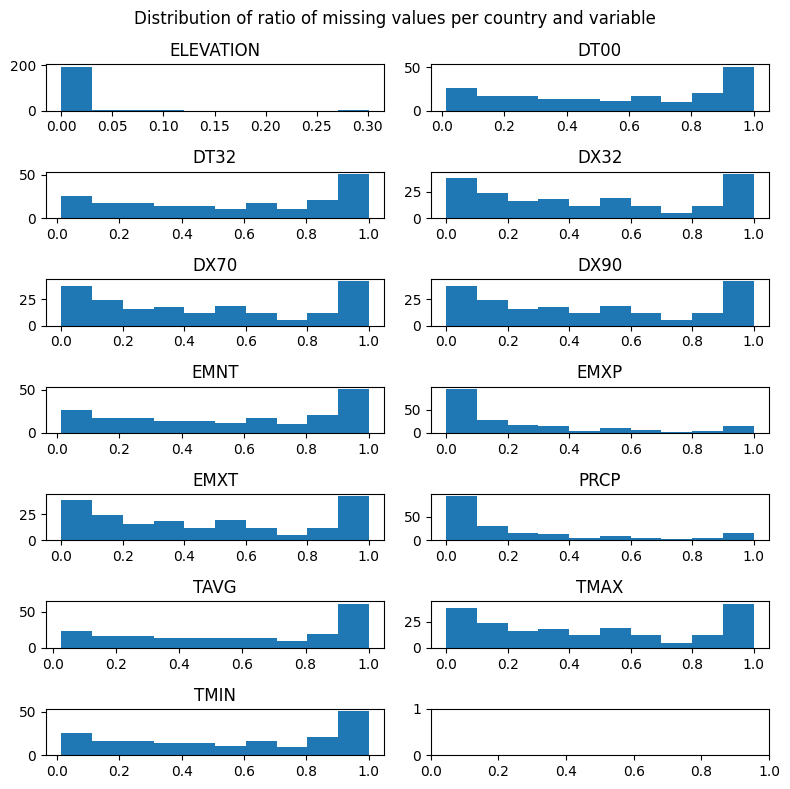

In [966]:
missing_per_country = df.groupby(["COUNTRY"]).agg(
    lambda x: x.isna().sum() / len(x)
)  # we use the number of total values to normalize

num_missing_country_vars = sum((missing_per_country > 0).any())

fig, axs = plt.subplots(num_missing_country_vars // 2 + 1, 2, figsize=(8, 8))
fig.suptitle("Distribution of ratio of missing values per country and variable")
axs = axs.flatten()
idx = 0
for var in missing_per_country.columns.values:
    if sum(missing_per_country[var]) > 0:
        axs[idx].hist(missing_per_country[var])
        axs[idx].set_title(var)
        idx += 1
plt.tight_layout()
plt.show()

### 1.7.1 Examine countries with high number of missing values

In [967]:
cutoff_countries = 0.99
print(f"Number of countries: {len(missing_per_country)}")
print(
    f"Number of countries with any variable >{cutoff_countries*100}% missing: {len(missing_per_country[(missing_per_country > cutoff_countries).any(axis=1)])}"
)

Number of countries: 198
Number of countries with any variable >99.0% missing: 48


We have 12 meteorological variables that are of our interest.


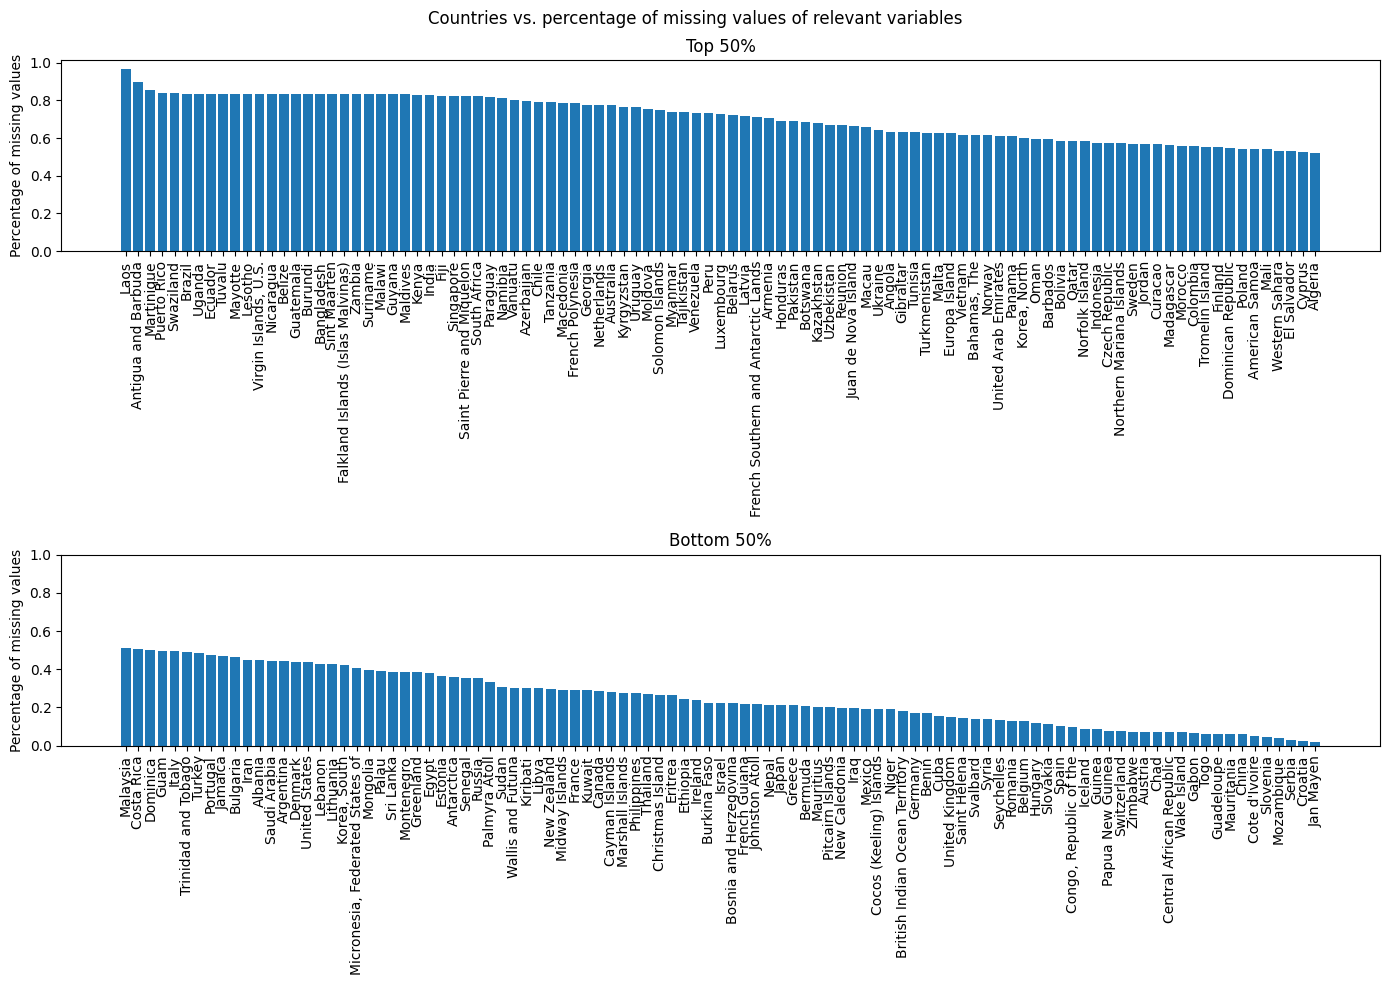

In [968]:
meteo_vars = [
    "DT00",
    "DT32",
    "DX32",
    "DX70",
    "DX90",
    "EMNT",
    "EMXP",
    "EMXT",
    "PRCP",
    "TAVG",
    "TMAX",
    "TMIN",
]

print(f"We have {len(meteo_vars)} meteorological variables that are of our interest.")

mmrpc = (missing_per_country[meteo_vars].sum(axis=1) / len(meteo_vars)).sort_values(
    ascending=False
)

mmrpc_first = mmrpc.iloc[: len(mmrpc) // 2]
mmrpc_second = mmrpc.iloc[len(mmrpc) // 2 :]
fig, axs = plt.subplots(2, figsize=(14, 10))
fig.suptitle("Countries vs. percentage of missing values of relevant variables")
axs[0].bar(mmrpc_first.index, mmrpc_first.values)
axs[0].tick_params(axis="x", labelrotation=90)
axs[0].set_ylabel(f"Percentage of missing values")
axs[0].set_title("Top 50%")

axs[1].bar(mmrpc_second.index, mmrpc_second.values)
axs[1].tick_params(axis="x", labelrotation=90)
axs[1].set_ylabel(f"Percentage of missing values")
axs[1].set_ylim((0, 1))
axs[1].set_title("Bottom 50%")
plt.tight_layout()

We will remove all countries where over 80% of the values are missing, as we don't expect them to be valuable for latter analysis.

In [969]:
countries_to_remove = list(mmrpc[mmrpc > 0.80].index)
print(
    f"The {len(countries_to_remove)} countries that will be removed are:\n {countries_to_remove}"
)

The 33 countries that will be removed are:
 ['Laos', 'Antigua and Barbuda', 'Martinique', 'Puerto Rico', 'Swaziland', 'Brazil', 'Uganda', 'Ecuador', 'Tuvalu', 'Mayotte', 'Lesotho', 'Virgin Islands, U.S.', 'Nicaragua', 'Belize', 'Guatemala', 'Burundi', 'Bangladesh', 'Sint Maarten', 'Falkland Islands (Islas Malvinas)', 'Zambia', 'Suriname', 'Malawi', 'Guyana', 'Maldives', 'Kenya', 'India', 'Fiji', 'Singapore', 'Saint Pierre and Miquelon', 'South Africa', 'Paraguay', 'Namibia', 'Vanuatu']


In [970]:
print(
    f"Data frame shape before removal of countries with >85% missing values: {df.shape}"
)
df = df[~df["COUNTRY"].isin(countries_to_remove)]
print(
    f"Data frame shape after removal of countries with >85% missing values: {df.shape}"
)

Data frame shape before removal of countries with >85% missing values: (1849753, 21)
Data frame shape after removal of countries with >85% missing values: (1625526, 21)


## 1.8 Group by `COUNTRY` and `DATE` and mean aggregate

In [971]:
by_country_date = df.groupby(["COUNTRY", "DATE"])[meteo_vars].agg("mean")
by_country_date.head()

DT00  DT32  DX32   DX70  DX90  EMNT    EMXP   EMXT     PRCP  \
COUNTRY DATE                                                                
Albania 1950   NaN   NaN   0.0  183.0  51.0   NaN   52.30  37.40  1155.50   
        1951   NaN   NaN   0.0  157.5  32.5   NaN   73.30  38.55  1390.40   
        1952   NaN   NaN   0.0  175.5  57.0   NaN  177.65  38.05  1887.90   
        1953   NaN   NaN   0.0  168.5  26.5   NaN   96.25  36.25  1090.75   
        1954   NaN   NaN   3.0  157.0  25.5   NaN  122.60  37.60  1602.10   

              TAVG    TMAX  TMIN  
COUNTRY DATE                      
Albania 1950   NaN  22.030   NaN  
        1951   NaN  20.785   NaN  
        1952   NaN  21.055   NaN  
        1953   NaN  20.245   NaN  
        1954   NaN  19.540   NaN

## 1.9 Interpolate missing values

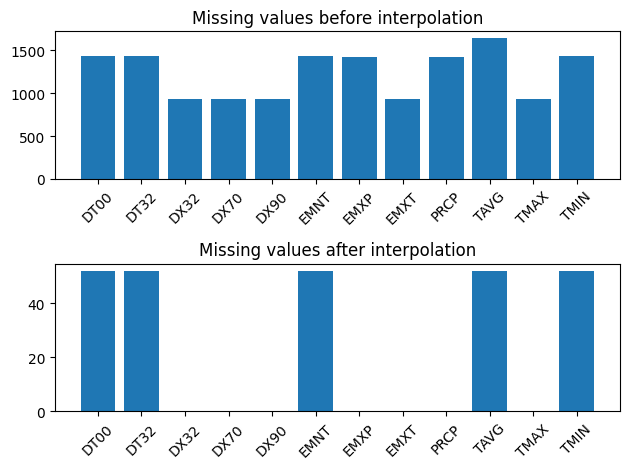

In [972]:
fig, axs = plt.subplots(2)

axs[0].bar(by_country_date.isna().sum().index, by_country_date.isna().sum().values)
axs[0].tick_params(axis="x", labelrotation=45)
axs[0].set_title("Missing values before interpolation")

by_country_date_interpolated = by_country_date.interpolate(limit_direction="forward")

axs[1].bar(
    by_country_date_interpolated.isna().sum().index,
    by_country_date_interpolated.isna().sum().values,
)
axs[1].tick_params(axis="x", labelrotation=45)
axs[1].set_title("Missing values after interpolation")
plt.tight_layout()
plt.show()

## 1.10 Remove records that still contain missing values

In [973]:
print(f"{by_country_date_interpolated.shape = }")

by_country_date_clean = by_country_date_interpolated.dropna()

print(f"{by_country_date_clean.shape = }")

display(by_country_date_clean.isna().sum())

by_country_date_interpolated.shape = (8089, 12)
by_country_date_clean.shape = (8037, 12)


DT00    0
DT32    0
DX32    0
DX70    0
DX90    0
EMNT    0
EMXP    0
EMXT    0
PRCP    0
TAVG    0
TMAX    0
TMIN    0
dtype: int64

## 1.11 Rename columns to speaking names

In [1035]:
df_gsoy = by_country_date_clean.reset_index()
df_gsoy = df_gsoy.rename(
    columns={
        "COUNTRY": "country",
        "DATE": "year",
        "DT00": "number_of_days_min_temp_most_0_fahreheit",
        "DT32": "number_of_days_min_temp_at_most_32_fahrenheit",
        "DX32": "number_of_days_max_temp_at_most_32_fahrenheit",
        "DX70": "number_of_days_max_temp_at_most_70_fahrenheit",
        "DX90": "number_of_days_max_temp_at_least_90_fahrenheit",
        "EMNT": "absolute_min_temp",
        "EMXT": "absolute_max_temp",
        "EMXP": "max_daily_precipitation",
        "PRCP": "total_precipitation",
        "TAVG": "average_annual_temp",
        "TMAX": "average_annual_max_temp",
        "TMIN": "average_annual_min_temp",
    }
)
df_gsoy.head()

,country,year,number_of_days_min_temp_most_0_fahreheit,number_of_days_min_temp_at_most_32_fahrenheit,number_of_days_max_temp_at_most_32_fahrenheit,number_of_days_max_temp_at_most_70_fahrenheit,number_of_days_max_temp_at_least_90_fahrenheit,absolute_min_temp,max_daily_precipitation,absolute_max_temp,total_precipitation,average_annual_temp,average_annual_max_temp,average_annual_min_temp
0,Algeria,1950,0.0,6.333333,0.0,267.000000,100.666667,-1.200000,25.45,41.933333,359.500000,20.073333,26.703333,13.440000
1,Algeria,1951,0.0,3.666667,0.0,265.666667,104.000000,-0.733333,21.00,40.833333,85.000000,20.586667,27.006667,14.163333
2,Algeria,1952,0.0,8.500000,0.0,254.500000,98.000000,-1.000000,8.00,44.950000,30.000000,20.450000,26.695000,14.215000
3,Algeria,1953,0.0,8.333333,0.0,262.666667,92.666667,-2.800000,27.55,40.666667,347.700000,20.190000,26.476667,13.900000
4,Algeria,1954,0.0,4.500000,0.0,247.750000,71.500000,-1.900000,22.00,41.725000,179.333333,19.312500,25.517500,13.110000


# 2. Enviromental and economical variables
Obtained from [Gapminder](https://www.gapminder.org/data/).

## 2.1 Load data

In [1036]:
gapminder_csv_files = list(
    filter(lambda fname: fname.endswith(".csv"), os.listdir(GAPMINDER_DATA_PATH))
)

print(f"{GAPMINDER_DATA_PATH} contains {len(gapminder_csv_files)} CSV files.")

gapminder_dfs = {}
for fname in tqdm(gapminder_csv_files, total=len(gapminder_csv_files)):
    tmp_df = pd.read_csv(os.path.join(GAPMINDER_DATA_PATH, fname))
    tmp_df = tmp_df.melt(id_vars=["country"])
    tmp_df = tmp_df.rename(
        columns={"variable": "year", "value": fname.split(".csv")[0]}
    )
    tmp_df = tmp_df.set_index(["country", "year"])
    gapminder_dfs[fname] = tmp_df

gapminder_df_full = pd.concat(list(gapminder_dfs.values()), axis=1).reset_index()
gapminder_df_full.head(10)

../data/raw/gapminder contains 19 CSV files.


100%|██████████████████████████████████████████| 19/19 [00:00<00:00, 113.08it/s]


,country,year,tsunami_affected_annual_number,co2_emissions_tonnes_per_person,inflation_annual_percent,cc_vser_somw_t_per,sulfur_emissions_per_person_kg,extreme_temperature_deaths_annual_number,flood_affected_annual_number,gdppercapita_us_inflation_adjusted,...,exports_percent_of_gdp,gdp_per_capita_yearly_growth,imports_percent_of_gdp,storm_affected_annual_number,population_total,cc_somw_t_per,flood_deaths_annual_number,storm_deaths_annual_number,tsunami_deaths_annual_number,extreme_temperature_affected_annual_number
0,Bangladesh,1979,NaN,0.0854,12.6,NaN,1.11,0,0,456,...,6.11,1.66,15.80,203,77.5M,NaN,0,53,NaN,0
1,France,1979,13.0,9.89,10.3,NaN,31.8,0,0,23.3k,...,20.70,2.96,20.30,0,53.6M,NaN,0,0,11.0,0
2,Honduras,1979,NaN,0.54,8.35,NaN,3.51,NaN,40k,1800,...,33.00,1.17,41.70,0,3.57M,NaN,1,0,NaN,NaN
3,Indonesia,1979,562.0,0.661,31.2,NaN,0.987,NaN,35k,999,...,30.10,2.66,23.60,0,144M,NaN,164,0,539.0,NaN
4,India,1979,NaN,0.433,15.7,NaN,1.79,400,28M,372,...,6.75,−7.27,8.17,1.61M,683M,NaN,253,594,NaN,400
5,Kenya,1979,NaN,0.318,5.64,NaN,2.62,NaN,0,1220,...,25.80,−0.0844,31.60,0,15.8M,NaN,0,0,NaN,NaN
6,Sri Lanka,1979,NaN,0.258,15.4,NaN,0.905,NaN,0,920,...,33.70,4.51,45.80,0,14.8M,NaN,0,0,NaN,NaN
7,Maldives,1979,NaN,0.191,NaN,NaN,NaN,NaN,0,NaN,...,NaN,7.51,NaN,0,153k,NaN,0,0,NaN,NaN
8,Myanmar,1979,NaN,0.152,3.28,NaN,0.0633,NaN,10k,184,...,NaN,2.96,NaN,0,33.5M,NaN,0,0,NaN,NaN
9,Malaysia,1979,NaN,2.03,12.1,NaN,6.36,NaN,0,2890,...,56.00,5.69,47.10,0,13.5M,NaN,0,0,NaN,NaN


## 2.2 Select relevant years
To keep the dataset size managable, we will only consider observations with `year >= 1950`.

In [1037]:
gapminder_df_full["year"] = gapminder_df_full["year"].astype(int)
gapminder_df_full_relevant_years = gapminder_df_full[gapminder_df_full["year"] >= 1950]

## 2.3 Examine missing values per variable

,variable,ndv,missing_absolute,missing_relative
0,country,240,0,0.000000
1,year,151,0,0.000000
2,tsunami_affected_annual_number,21,32393,0.999260
3,co2_emissions_tonnes_per_person,2743,19942,0.615171
4,inflation_annual_percent,2898,22820,0.703952
5,cc_vser_somw_t_per,203,32156,0.991949
6,sulfur_emissions_per_person_kg,2596,23186,0.715242
7,extreme_temperature_deaths_annual_number,136,29789,0.918931
8,flood_affected_annual_number,1013,25397,0.783447
9,gdppercapita_us_inflation_adjusted,2234,22822,0.704013


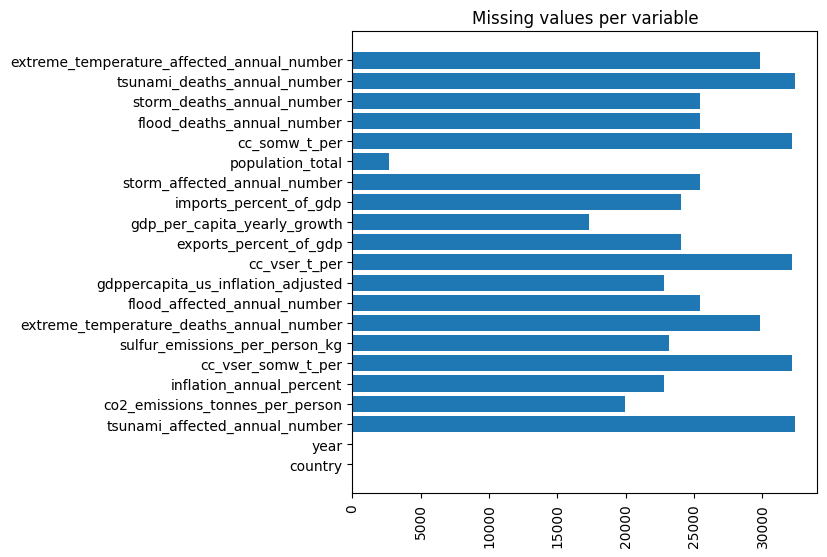

In [1038]:
df = gapminder_df_full_relevant_years.copy()

variable_descriptions = []
for var in df.columns.values:
    desc = {
        "variable": var,
        "ndv": df[var].nunique(),
        "missing_absolute": df[var].isna().sum(),
        "missing_relative": df[var].isna().sum() / len(df[var]),
    }
    variable_descriptions.append(desc)
variable_descriptions = pd.DataFrame(variable_descriptions)
display(variable_descriptions)


def plot_na_per_var(df):
    fig, ax = plt.subplots(1, figsize=(6, 6))
    ax.barh(df.isna().sum().index, df.isna().sum().values)
    ax.set_title("Missing values per variable")
    ax.tick_params(axis="x", labelrotation=90)
    # plt.tight_layout()
    plt.show()


plot_na_per_var(df)

## 2.4 Transform xx`k`, xx`M` and xx`B` strings to numbers  

In [1039]:
def replace_chars_by_vals(value):
    try:
        value = float(value)
    except Exception as e:
        if "k" in value:
            value = float(value.split("k")[0]) * 1000
        elif "M" in value:
            value = float(value.split("M")[0]) * 1_000_000
        elif "B" in value:
            value = float(value.split("B")[0]) * 1_000_000_000
    return value


for col in df.columns.values:
    if not col in ["country", "year"]:
        df[col] = df[col].copy().apply(replace_chars_by_vals)

In [1040]:
df.head()

,country,year,tsunami_affected_annual_number,co2_emissions_tonnes_per_person,inflation_annual_percent,cc_vser_somw_t_per,sulfur_emissions_per_person_kg,extreme_temperature_deaths_annual_number,flood_affected_annual_number,gdppercapita_us_inflation_adjusted,...,exports_percent_of_gdp,gdp_per_capita_yearly_growth,imports_percent_of_gdp,storm_affected_annual_number,population_total,cc_somw_t_per,flood_deaths_annual_number,storm_deaths_annual_number,tsunami_deaths_annual_number,extreme_temperature_affected_annual_number
0,Bangladesh,1979,NaN,0.0854,12.6,NaN,1.110,0.0,0.0,456.0,...,6.11,1.66,15.80,203.0,77500000.0,NaN,0.0,53.0,NaN,0.0
1,France,1979,13.0,9.8900,10.3,NaN,31.800,0.0,0.0,23300.0,...,20.70,2.96,20.30,0.0,53600000.0,NaN,0.0,0.0,11.0,0.0
2,Honduras,1979,NaN,0.5400,8.35,NaN,3.510,NaN,40000.0,1800.0,...,33.00,1.17,41.70,0.0,3570000.0,NaN,1.0,0.0,NaN,NaN
3,Indonesia,1979,562.0,0.6610,31.2,NaN,0.987,NaN,35000.0,999.0,...,30.10,2.66,23.60,0.0,144000000.0,NaN,164.0,0.0,539.0,NaN
4,India,1979,NaN,0.4330,15.7,NaN,1.790,400.0,28000000.0,372.0,...,6.75,−7.27,8.17,1610000.0,683000000.0,NaN,253.0,594.0,NaN,400.0


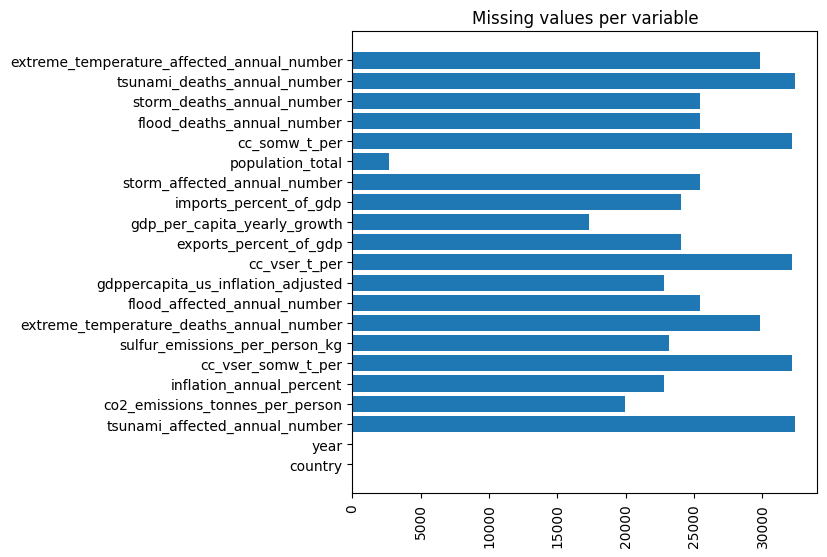

In [1041]:
plot_na_per_var(df)

## 2.5 Fill missing values with 0 for selected variables
For the following variables, we will assume that a missing value means that no case occurred and we will therefore fill them with 0:
- tsunami_affected_annual_number
- extreme_temperature_deaths_annual_number
- flood_affected_annual_number
- storm_affected_annual_number
- flood_deaths_annual_number
- storm_deaths_annual_number
- tsunami_deaths_annual_number
- extreme_temperature_affected_annual_number

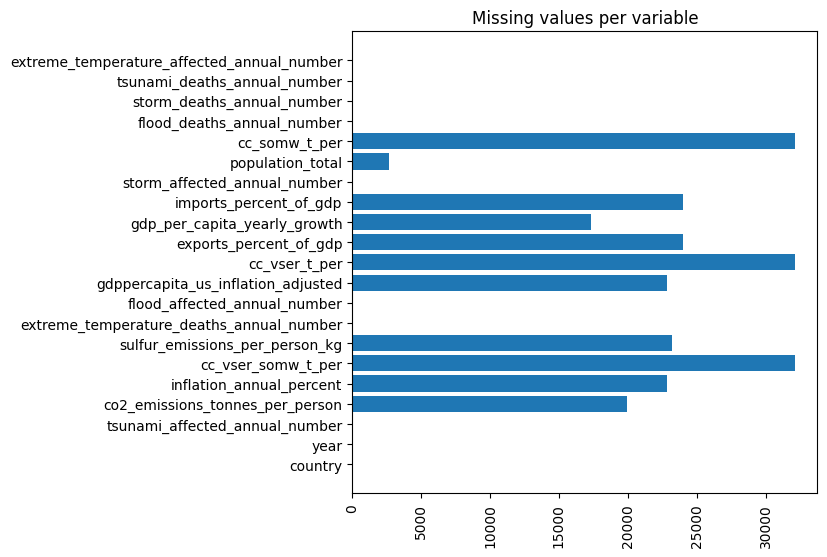

,country,year,tsunami_affected_annual_number,co2_emissions_tonnes_per_person,inflation_annual_percent,cc_vser_somw_t_per,sulfur_emissions_per_person_kg,extreme_temperature_deaths_annual_number,flood_affected_annual_number,gdppercapita_us_inflation_adjusted,...,exports_percent_of_gdp,gdp_per_capita_yearly_growth,imports_percent_of_gdp,storm_affected_annual_number,population_total,cc_somw_t_per,flood_deaths_annual_number,storm_deaths_annual_number,tsunami_deaths_annual_number,extreme_temperature_affected_annual_number
0,Bangladesh,1979,0.0,0.0854,12.6,NaN,1.110,0.0,0.0,456.0,...,6.11,1.66,15.80,203.0,77500000.0,NaN,0.0,53.0,0.0,0.0
1,France,1979,13.0,9.8900,10.3,NaN,31.800,0.0,0.0,23300.0,...,20.70,2.96,20.30,0.0,53600000.0,NaN,0.0,0.0,11.0,0.0
2,Honduras,1979,0.0,0.5400,8.35,NaN,3.510,0.0,40000.0,1800.0,...,33.00,1.17,41.70,0.0,3570000.0,NaN,1.0,0.0,0.0,0.0
3,Indonesia,1979,562.0,0.6610,31.2,NaN,0.987,0.0,35000.0,999.0,...,30.10,2.66,23.60,0.0,144000000.0,NaN,164.0,0.0,539.0,0.0
4,India,1979,0.0,0.4330,15.7,NaN,1.790,400.0,28000000.0,372.0,...,6.75,−7.27,8.17,1610000.0,683000000.0,NaN,253.0,594.0,0.0,400.0


In [1042]:
zero_cols = [
    "tsunami_affected_annual_number",
    "extreme_temperature_deaths_annual_number",
    "flood_affected_annual_number",
    "storm_affected_annual_number",
    "flood_deaths_annual_number",
    "storm_deaths_annual_number",
    "tsunami_deaths_annual_number",
    "extreme_temperature_affected_annual_number",
]
df[zero_cols] = df[zero_cols].copy().fillna(0)

plot_na_per_var(df)
df.head()

## 2.6 Interpolate missing values for remaining variables
We will use linear interpolation to impute the missing values for the variables:
- population_total
- imports_percent_of_gdp
- gdp_per_capita_yearly_growth
- exports_percent_of_gdp
- gdppercapita_us_inflation_adjusted
- sulfur_emissions_per_person_kg
- inflation_annual_percent
- co2_emissions_tonnes_per_person

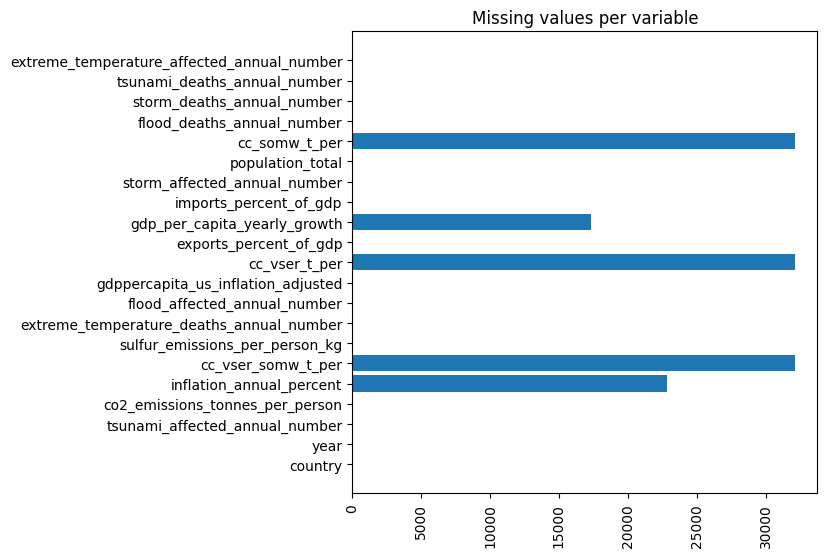

In [1043]:
tmp = df.groupby(["country", "year"]).agg("first")

interpolate_cols = [
    "population_total",
    "imports_percent_of_gdp",
    "gdp_per_capita_yearly_growth",
    "exports_percent_of_gdp",
    "gdppercapita_us_inflation_adjusted",
    "sulfur_emissions_per_person_kg",
    "inflation_annual_percent",
    "co2_emissions_tonnes_per_person"
]

tmp.loc[:, interpolate_cols] = tmp.loc[:, interpolate_cols].interpolate()

df = tmp.reset_index()
plot_na_per_var(df)

## 2.7 Remove records with `year > 2022` (coming from population_total table) 

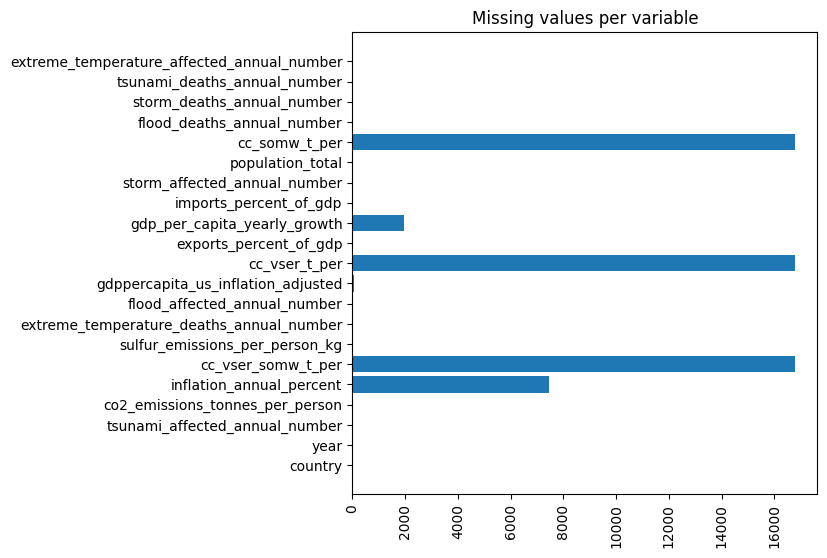

In [1044]:
df = df[df["year"] <= 2022]
plot_na_per_var(df)

## 2.8 Remove countries that have still missing values for selected columns

In [1045]:
print(
    f"Countries that have still missing values for gdppercapita_us_inflation_adjusted: {df.loc[df['gdppercapita_us_inflation_adjusted'].isna(), 'country'].unique()}"
)
print(
    f"Countries that have still missing values for imports_percent_of_gdp: {df.loc[df['imports_percent_of_gdp'].isna(), 'country'].unique()}"
)
print(
    f"Countries that have still missing values for exports_percent_of_gdp: {df.loc[df['exports_percent_of_gdp'].isna(), 'country'].unique()}"
)

Countries that have still missing values for gdppercapita_us_inflation_adjusted: ['Afghanistan']
Countries that have still missing values for imports_percent_of_gdp: ['Afghanistan']
Countries that have still missing values for exports_percent_of_gdp: ['Afghanistan']


In [1046]:
df_gapminder = df[df["country"] != "Afghanistan"]

# 3. Join datasets

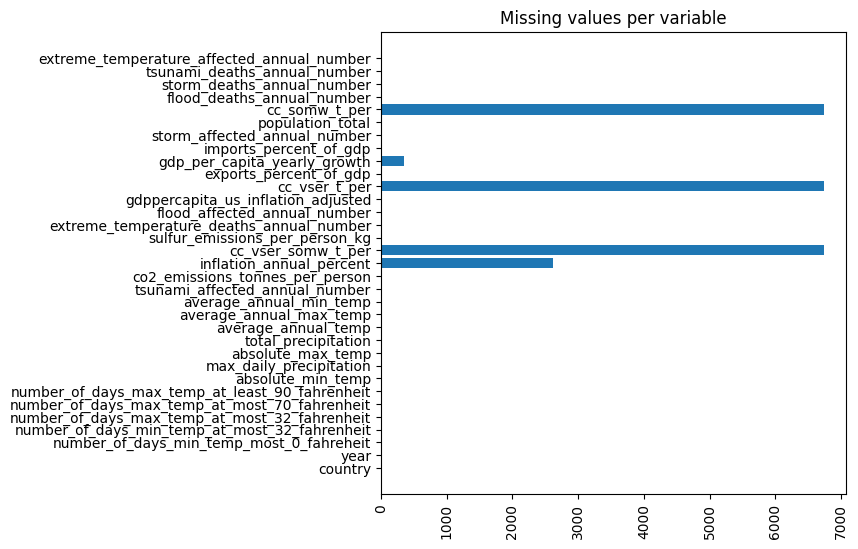

,country,year,number_of_days_min_temp_most_0_fahreheit,number_of_days_min_temp_at_most_32_fahrenheit,number_of_days_max_temp_at_most_32_fahrenheit,number_of_days_max_temp_at_most_70_fahrenheit,number_of_days_max_temp_at_least_90_fahrenheit,absolute_min_temp,max_daily_precipitation,absolute_max_temp,...,exports_percent_of_gdp,gdp_per_capita_yearly_growth,imports_percent_of_gdp,storm_affected_annual_number,population_total,cc_somw_t_per,flood_deaths_annual_number,storm_deaths_annual_number,tsunami_deaths_annual_number,extreme_temperature_affected_annual_number
0,Algeria,1950,0.0,6.333333,0.0,267.000000,100.666667,-1.200000,25.45,41.933333,...,37.252747,0.432,63.891209,0.0,8870000.0,NaN,0.0,0.0,0.0,0.0
1,Algeria,1951,0.0,3.666667,0.0,265.666667,104.000000,-0.733333,21.00,40.833333,...,37.427473,−1.3,64.212088,0.0,9020000.0,NaN,0.0,0.0,0.0,0.0
2,Algeria,1952,0.0,8.500000,0.0,254.500000,98.000000,-1.000000,8.00,44.950000,...,37.602198,2.15,64.532967,0.0,9190000.0,NaN,0.0,0.0,0.0,0.0
3,Algeria,1953,0.0,8.333333,0.0,262.666667,92.666667,-2.800000,27.55,40.666667,...,37.776923,−0.517,64.853846,0.0,9360000.0,NaN,0.0,0.0,0.0,0.0
4,Algeria,1954,0.0,4.500000,0.0,247.750000,71.500000,-1.900000,22.00,41.725000,...,37.951648,4.99,65.174725,0.0,9560000.0,NaN,0.0,0.0,0.0,0.0


In [1047]:
df_joined = pd.merge(df_gsoy, df_gapminder, on=["country", "year"])
plot_na_per_var(df_joined)
df_joined.head()

In [1049]:
meta_variables = ["year", "country"]
environmental_variables = [
    "extreme_temperature_affected_annual_number",
    "storm_affected_annual_number",
    "storm_deaths_annual_number",
    "cc_vser_t_per",
    "flood_affected_annual_number",
    "extreme_temperature_deaths_annual_number",
    "sulfur_emissions_per_person_kg",
    "cc_vser_somw_t_per",
    "tsunami_deaths_annual_number",
    "co2_emissions_tonnes_per_person",
    "tsunami_affected_annual_number",
    "cc_somw_t_per",
    "flood_deaths_annual_number"
]
economical_variables = [
    "population_total",
    "imports_percent_of_gdp",
    "exports_percent_of_gdp",
    "gdppercapita_us_inflation_adjusted",
    "gdp_per_capita_yearly_growth",
    "inflation_annual_percent"
]
meteorological_variables = [
    "average_annual_min_temp",
    "average_annual_max_temp",
    "average_annual_temp",
    "total_precipitation",
    "absolute_max_temp",
    "max_daily_precipitation",
    "absolute_min_temp",
    "number_of_days_max_temp_at_least_90_fahrenheit",
    "number_of_days_max_temp_at_most_70_fahrenheit",
    "number_of_days_max_temp_at_most_32_fahrenheit",
    "number_of_days_min_temp_at_most_32_fahrenheit",
    "number_of_days_min_temp_most_0_fahreheit"
]

assert len(meta_variables + environmental_variables + economical_variables + meteorological_variables) == len(df_joined.columns.values)

## 3.1 Save wrangled dataset to file

In [1048]:
PROCESSED_DATA_PATH = "../data/processed"
os.makedirs(PROCESSED_DATA_PATH, exist_ok=True)
df_joined.to_csv(os.path.join(PROCESSED_DATA_PATH, "wrangled_data.csv"), index=None)